In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Get train and test datasets from torchvision
train_dataset = torchvision.datasets.MNIST(
    root = '.', # specify downloading path
    train = True, # we want to get train set
    transform = transforms.ToTensor(), # convert data to torch tensors
    download = True, # download it from cloud
)
# This returns train_x and train_y as train_dataset.data and train_dataset.target


test_dataset = torchvision.datasets.MNIST(
    root = '.', # specify downloading path
    train = False, # we want to get test set
    transform = transforms.ToTensor(), # convert data to torch tensors
    download = True, # download it from cloud
)
# this returns the same as above but with test

In [3]:
train_dataset.data.max() # what's the maximum pixel value for given data?
# so the data is 8bit integer and maximum value is 255.

tensor(255, dtype=torch.uint8)

In [4]:
train_dataset.data.shape # we have 60k samples of 28x28 images

torch.Size([60000, 28, 28])

In [5]:
train_dataset.targets.shape # we have 60k target value.

torch.Size([60000])

In [6]:
# Build the model

# Since the data is 28x28, one image contains 784 in it.
# We convert them to flat arrays of images. So 1 sample will have the
# shape of (,784). It's clear that the layer will process 784 pixels.
model = nn.Sequential(
    nn.Linear(784, 128), # 128 in here is hyper-parameter for output value
    nn.ReLU(), # well, when we didn't use ReLU?
    nn.Linear(128, 10) # (NOTE)
)
#NOTE:
# First linear layer's output is (,128). 
# And in neural networks, one layer's output is the next one's input. 
# We need to specify 128 as a input size of 2nd Linear layer because layer's input will be the output of the first layer which outputs in the size of 128.
# Also we didn't add a layer for Softmax activation function since we apply it with cost function.

In [7]:
# If we have a ready-for-use GPU device, it'll be specified as "cuda:0"
# So we're checking if this string is in available device list. 
# If it doesn't available, we'll use "cpu" device.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device) # specify which device we will use to make computations with model.

cuda:0


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
)

In [8]:
# Define cost and optimizer objects.
# If you want to add seperate Softmax layer to the model, 
# you should use nn.NLLLoss as a Loss function.
# In PyTorch, CrossEntropyLoss() applies softmax function to given input data
# So we'll need to process the predictions before getting what we want.
criterion = nn.CrossEntropyLoss() # applies Softmax automatically
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [9]:
# Data loader is useful 
# because it automatically generates batches in the training loop and 
# takes care of shuffling

batch_size = 128 # doesn't have to do anything with 128 in the model layers
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True,
)

test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle = False,
)

In [10]:
# The DataLoader maps the values to (0,1),
# makes the data of shape (batch_size, color, height, width)
tmp_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = 1,
    shuffle = True)

for x, y in tmp_loader:
  print(x)
  print(x.shape)
  print(y.shape)
  break

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [12]:
# measure the time for 1 epoch
import time

# Train the model
n_epochs = 10

# To store the loss
train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

# apply batch gradient descent
for i in range(n_epochs):
  t0 = time.time()

  train_loss = []
  test_loss = []

  # train loop
  for inputs, targets in train_loader:
    # move data to GPU device
    inputs, targets = inputs.to(device), targets.to(device)

    # reshape the input to have flat array of images
    inputs = inputs.view(-1, 784) # 28x28 = 784

    # Forward propagation
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backprop
    loss.backward()
    optimizer.step()
    # zero the parameter gradients in order to prevent gradient accumulation
    optimizer.zero_grad()

    # store the loss
    train_loss.append(loss.item()) # we still want one element but as matrix

  # test prediction loop  
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1, 784)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    test_loss.append(loss.item())
  
  # since we have arrays of losses, it's good to compare with means
  train_loss = np.mean(train_loss)
  test_loss = np.mean(test_loss)

  # save the losses to main arrays
  train_losses[i] = train_loss
  test_losses[i] = test_loss

  # print out the log
  t1 = time.time()
  print(f"Epoch {i+1}/{n_epochs} done in {t1 - t0:.3f}s, train loss: {train_loss:.4f} | test loss: {test_loss:.4f}")

Epoch 1/10 done in 13.263s, train loss: 0.2247 | test loss: 0.1197
Epoch 2/10 done in 13.114s, train loss: 0.1099 | test loss: 0.0780
Epoch 3/10 done in 13.421s, train loss: 0.0879 | test loss: 0.0607
Epoch 4/10 done in 13.357s, train loss: 0.0725 | test loss: 0.0490
Epoch 5/10 done in 13.234s, train loss: 0.0666 | test loss: 0.0557
Epoch 6/10 done in 13.384s, train loss: 0.0612 | test loss: 0.0491
Epoch 7/10 done in 13.338s, train loss: 0.0542 | test loss: 0.0447
Epoch 8/10 done in 13.354s, train loss: 0.0531 | test loss: 0.0490
Epoch 9/10 done in 13.423s, train loss: 0.0443 | test loss: 0.0443
Epoch 10/10 done in 13.362s, train loss: 0.0503 | test loss: 0.0408


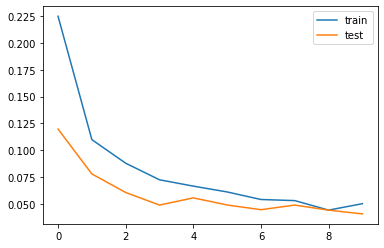

In [13]:
# plot the losses
plt.plot(train_losses, label = 'train')
plt.plot(test_losses, label = 'test')
plt.legend()
plt.show()

In [14]:
# make predictions and calculate accuracies

# for train
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  inputs = inputs.view(-1, 784)
  # forward pass
  outputs = model(inputs)
  # torch.max returns both maximum value and argmax
  _, preds = torch.max(outputs, 1) # specify axis = 1 in order to pick maximum for a column.

  n_correct += (preds == targets ).sum().item() # add up the correct prediction count
  n_total += targets.shape[0] # add up the batch size
train_acc = n_correct / n_total

# for test
n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  inputs = inputs.view(-1, 784)
  # forward pass
  outputs = model(inputs)
  # torch.max returns both maximum value and argmax
  _, preds = torch.max(outputs, 1) # specify axis = 1 in order to pick maximum for a column.

  n_correct += (preds == targets).sum().item() # add up the correct prediction count
  n_total += targets.shape[0] # add up the batch size
test_acc = n_correct / n_total

print(f"Train Accuracy: {train_acc:.3f}, Test Accuracy: {test_acc:.3f}")

Train Accuracy: 0.988, Test Accuracy: 0.972


In [15]:
# Plot confusion matrix (code snippet)
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


Confusion matrix, without normalization
[[ 967    0    4    0    1    2    2    0    2    2]
 [   0 1125    5    0    0    0    1    0    4    0]
 [   1    3 1009    1    0    1    1   11    2    3]
 [   0    2    7  982    0    4    0    3    3    9]
 [   0    1    8    0  934    0    3    4    1   31]
 [   1    2    0    9    1  855    6    1    8    9]
 [   2    2    3    2    3    5  935    0    3    3]
 [   1    6   10    3    0    0    0  999    0    9]
 [   8    0    3    7    4    4    5    4  931    8]
 [   0    4    0    4    4    1    1    5    3  987]]


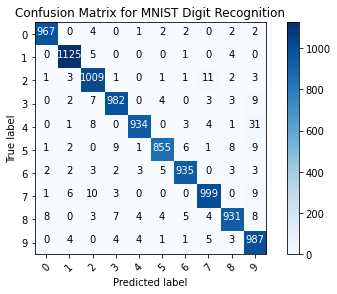

In [16]:
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
  inputs = inputs.to(device)
  inputs = inputs.view(-1, 784)
  outputs = model(inputs)
  _, preds = torch.max(outputs, 1) # this returns maximum value and argmax but I only need argmax since it represents the same label for image.

  # concatenate preds with p_test
  # I use .cpu() to copy predictions to the CPU. Since model calculated it on GPU, I need to get it back to CPU in order to make something with it. 
  # Because we're doing our calculations (operations) mainly on CPU.
  p_test = np.concatenate((p_test, preds.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)), title = 'Confusion Matrix for MNIST Digit Recognition')

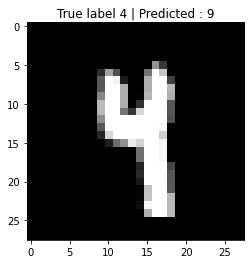

In [17]:
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap = 'gray')
plt.title("True label %s | Predicted : %s" % (y_test[i], int(p_test[i])));